In [1]:
from astropy.table import Table

import numpy as np

import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')
from dark_matter_mass_v1 import rot_fit_BB

import pandas
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib notebook

# Data

In [2]:
gal_filename = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_v5.txt'

gal = Table.read(gal_filename, format='ascii.commented_header')

### Remove bad fit galaxies

In [18]:
################################################################################
# Calculate the velocity at R90
#-------------------------------------------------------------------------------
# Convert r from arcsec to kpc
#-------------------------------------------------------------------------------
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

dist_to_galaxy_Mpc = c*gal['NSA_redshift']/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

gal['R90_kpc'] = dist_to_galaxy_kpc*np.tan(gal['NSA_elpetro_th90']*(1./60)*(1./60)*(np.pi/180))
#-------------------------------------------------------------------------------

gal['V90_kms'] = rot_fit_BB(gal['R90_kpc'], 
                            [gal['Vmax_map'], 
                             gal['Rturn_map'], 
                             gal['alpha_map']])
################################################################################


bad_boolean = np.logical_or.reduce([np.isnan(gal['M90_map']), 
                                    np.isnan(gal['M90_disk_map']), 
                                    gal['alpha_map'] > 99, 
                                    gal['ba_map'] > 0.998, 
                                    gal['V90_kms']/gal['Vmax_map'] < 0.9])

sample = gal[~bad_boolean]

print(len(sample))

1996


# Tidal debris

How many of our objects exhibit tidal debris?

In [4]:
np.sum(sample['Tidal'])

338

How does the visual morphological tidal classifications compare to the deep learning results?

<IPython.core.display.Javascript object>


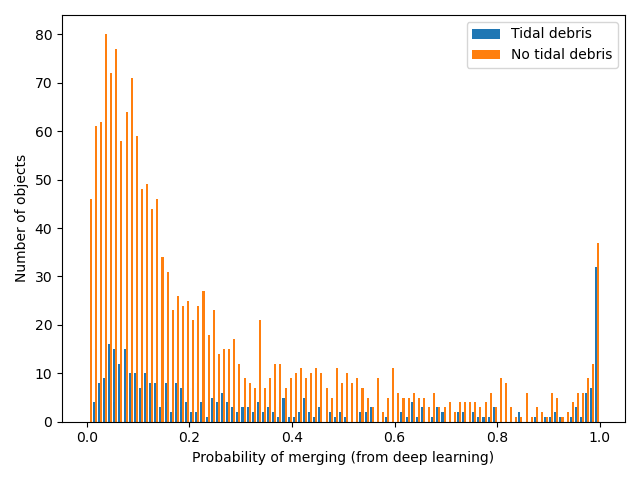

In [15]:
plt.figure()

plt.hist([sample['DL_merge'][sample['Tidal'].astype(bool)], 
          sample['DL_merge'][~sample['Tidal'].astype(bool)]], 
         bins=100)

plt.xlabel('Probability of merging (from deep learning)')
plt.ylabel('Number of objects')

plt.legend(['Tidal debris', 'No tidal debris'])

plt.tight_layout();

Not a great correlation.  However, after visual inspection, objects with both visually-inspected tidal debris and have a high DL merge probability do not have good velocity maps and should be removed from the analysis.

**Q:** What is the smallest DL merge probability that should be removed?
**A:** 0.97

In [14]:
sample[(sample['DL_merge'] > 0.97) & (sample['Tidal'].astype(bool))].show_in_notebook()

idx,MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,Hubble_type,Tidal,GZ_edge_on,GZ_bar,GZ_spiral,mangaid,DL_ttype,DL_s0,DL_edge_on,DL_bar_GZ2,DL_bar_N10,DL_merge,R90_kpc,V90_kms
0,8456,12702,942,526,52703,176731,149.96826357106832,45.28309587837217,0.20758776366710663,106.93988037109375,0.023488938808441162,2254311424.0,1.0,64.10504584471593,1.5637229470327922,35.080502790834935,19.0440012021705,7.31683154616175,89.19677355505709,6.263520248063275,29.63670516014609,56.97872406745869,47.404176343567954,39.22254959592306,1.871915566378415,87.00030886276652,585.9716327913941,7.047885090375622,0.051103781908750534,0.00170629366939515,5219180182.641645,254624345.86024046,1220624448.4106731,254624345.86024046,3998555734.2309723,0.3052663335316574,0.06367907884350434,-19.15823745727539,4.098340992376969,0.16311945269311806,3.799915936577332,0.26021705847848287,4.754137566128594,0.2860559543161788,-99.0,-99.0,1.0,0,0,0.5628331958585961,3.646475103351381,0.5421450069519709,876963,7.492393562477842,1.1994436383247375,0.22413273001508296,5.462342765559089,1.3052663335316574,0.06367907884350434,1.1215848789244751,90.83763740880217,64.89121580988719,-1.5420922013377243,0.8446064219150263,0.9994681804717492,327.7350338005445,0.9929320921778241,12.447600055875071,7.779623491756222,37.539813476053936,0.9262910611314578,45.807424442546576,4.779064009982642,167.8266900371234,6.162811013046655,5.599646107205671,0.9000740055852013,5.740987675239007,0.07223561926956971,10.886853661543737,9.752801477913243,290.3914766671922,7.124202351457252,1.7081473090611243,0.03236838905039425,9.72621435992587,10.647455128539178,0.7002323069852942,34.469398498535156,419.77478208989237,18936384.450972,9.982501983642578,160.5205399425769,186.52353690295175,1,-2.0,Scd,1,0.21212121212121213,0.2692307692307692,0.6538461538461539,1-167148,6.375168800354004,0.9401218891143799,0.15634484589099884,0.05967767909169197,0.29675519466400146,0.9977738261222839,11.767729454623867,167.29373199600036
1,8978,12702,0,0,0,686985,249.58776886171256,40.817208556211845,0.6208126544952393,35.72662353515625,0.13301555812358856,78020378624.0,-9.0,563.4856963362172,66.54982294369152,0.676768396041831,1.0352194145539477,56.4340871297796,282.43977103698097,24.026244426076776,1.3409906814360406,0.14331101158248669,53.00651628069283,6328.369718521762,13608.567545175829,0.21989417533887834,0.35856146421042945,525.4582171239335,0.03339860588312149,0.000964758922969337,2283614002023.6636,539407155079.32416,1941626686106.6782,539407155079.32416,341987315916.98535,5.677481578229037,1.5772724015596558,-22.298851013183594,7.153278125890887,26.489709006426388,6.664377921953416,0.4378123143637868,9.893135735454093,50.3304293364593,-99.0,-99.0,1.0,0,5,7.05426089122245,6.625814535086604,65.68227714049169,-1,-99.0,1.9024880230426788,0.5195121951219512,30.932711671166697,6.677481578229037,1.5772724015596558,1.2035331919713674,33

# Morphologies

What are the different morphologies listed in the catalog?

In [16]:
labels_gal, counts_gal = np.unique(gal['Hubble_type'], return_counts=True)
#labels_sample, counts_s = np.unique(sample['Hubble_type'], return_counts=True)

## Distribution of Hubble types

<IPython.core.display.Javascript object>


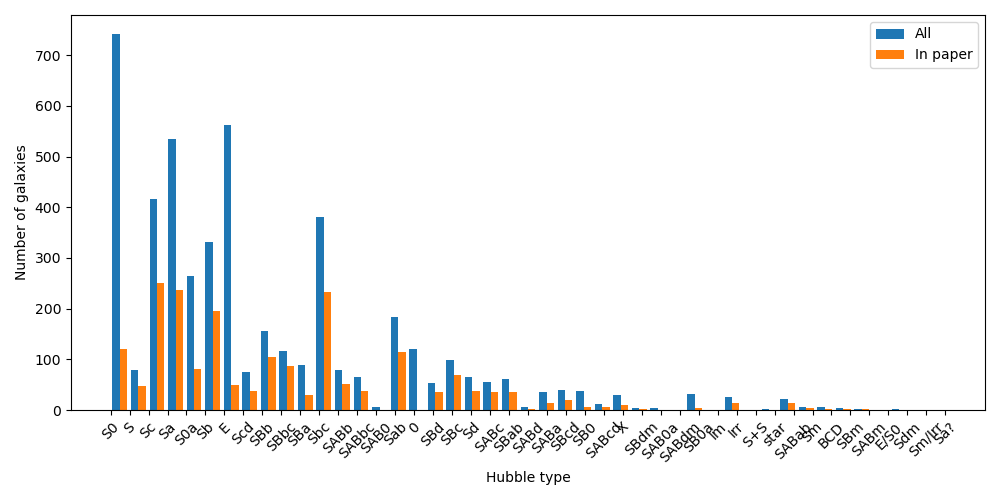

In [17]:
plt.figure(figsize=(10,5))

plt.hist([gal['Hubble_type'], sample['Hubble_type']], bins=len(labels_gal))

plt.xticks(rotation=45)

plt.xlabel('Hubble type')
plt.ylabel('Number of galaxies')

plt.legend(['All', 'In paper'])

plt.tight_layout();

'''
sample_morph_counts = Counter(sample['Hubble_type'].compressed())
gal_morph_counts = Counter(gal['Hubble_type'].compressed())

df_sample = pandas.DataFrame.from_dict(sample_morph_counts, orient='index')
df_gal = pandas.DataFrame.from_dict(gal_morph_counts, orient='index')

df_sample.plot(kind='bar')
df_gal.plot(kind='bar')
''';

In [27]:
sample.sort('chi2_map')

barred_boolean = np.logical_or.reduce([sample['Hubble_type'] == 'SBb', 
                                       sample['Hubble_type'] == 'SBbc', 
                                       sample['Hubble_type'] == 'SBa', 
                                       sample['Hubble_type'] == 'SBd', 
                                       sample['Hubble_type'] == 'SBc', 
                                       sample['Hubble_type'] == 'SBab', 
                                       sample['Hubble_type'] == 'SBcd']) & (sample['GZ_bar'] > 0.5) & np.logical_or(sample['DL_bar_GZ2'] > 0.5, 
                                                                                                                    sample['DL_bar_N10'] > 0.5)

sample[barred_boolean & (sample['MaNGA_IFU'] == 9102)].show_in_notebook()

idx,MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,Hubble_type,Tidal,GZ_edge_on,GZ_bar,GZ_spiral,mangaid,DL_ttype,DL_s0,DL_edge_on,DL_bar_GZ2,DL_bar_N10,DL_merge,R90_kpc,V90_kms
0,8086,9102,1242,409,52901,242465,57.24838235998747,0.9259771233409926,0.5271552801132202,48.2264404296875,0.03578799590468407,30723753984.0,-9.0,251.42815396757956,7.146740227447591,100.0,196.01154557434123,61.212486421331626,239.7988064587351,1.2873162041825685,100.0,257.9463465895274,291.34609594472226,262.9175673587246,1.138897730357049,5.260692636658911,0.3475430492963047,290.6578271539389,0.1686001420021057,0.00206159376648642,107035467194.43169,6084877344.618845,34238574977.538483,6084877344.618845,72796892216.8932,0.47033017392455523,0.08358704828345395,-20.594087600708008,2.2096191955563693,0.13289811302853774,2.4618695640231536,0.039515157502521533,1.6725173889163716,0.03310559776110725,-99.0,-99.0,5.0,0,0,5.56477149284833,26.48600872224748,26.423438832176263,3708,9.64403456771908,2.4143071472644806,0.03824247355573637,7.282172870954183,1.4703301739245553,0.08358704828345395,1.301590611285163,253.95533714974167,277.6314391286563,-70.30177571373407,0.5575956252593685,0.9976774737858815,53.32076121583151,1.170493254393006,26.559249455945295,5.211658986483638,32.132908006268195,0.6524109799433968,31.672133570386126,0.7401931034378179,241.57928646260905,14.060099526040595,2.082259880781901,0.8041579321557126,2.179975729202156,0.8416547610151862,11.100869817544044,10.166828513921562,6176.398087228127,512.3143044999659,1.2346776560226513,0.06094607094080634,10.772018850940574,13.691008215258448,0.5406920794144418,17.872190475463867,4.594656043304733,59512017.03181228,10.184037208557129,1150.9105449203016,1321.8406756528443,1,0.09786929488182068,SBb,0,0.08441905619495174,0.7534499185542614,0.7841841595721794,1-229060,2.530630350112915,0.8631482124328613,0.00041103342664428055,0.9743760228157043,0.8991509675979614,0.7861538529396057,9.2963129250284,236.1135837570235
1,8551,9102,1333,457,52782,262448,235.669362291793,45.432085787017904,0.4868888854980469,88.14520263671875,0.037613511085510254,2353333248.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-18.54295539855957,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-99.0,-99.0,1.0,-99,1,-1.0,-1.0,-1.0,999548,8.949728977920467,1.667272001504898,1.0,-1.0,-1.0,-1.0,-99.0,-1.0,-1.0,-1.0,0.9299525340197904,0.7629968572050566,59.54527303754933,3.7241005601691026,-2.6293583454452887,13.897084157896526,29.470114499528506,4.02346894500035,30.814603661155346,1.1536847506704164,224.09007069116223,386.8870681374054,8.485840803999936,11.982360675452485,3.113379842962302,0.47103518010237305,10.787566985208146,11.32575858075098,570.1392858752803,19.828872318517885,1.07470072118425,0.02567572898324214,9.616168995023644,11.18092325175103,0.7138759792676593,9.60600471496582,6.075582

In [28]:
sample[(sample['MaNGA_plate'] == 8997) & (sample['MaNGA_IFU'] == 9102)]

MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,Hubble_type,Tidal,GZ_edge_on,GZ_bar,GZ_spiral,mangaid,DL_ttype,DL_s0,DL_edge_on,DL_bar_GZ2,DL_bar_N10,DL_merge,R90_kpc,V90_kms
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str6,int64,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64
8997,9102,878,621,52353,158131,171.06556702682258,51.742307135216784,0.8592228889465332,126.90560913085938,0.03257821500301361,19881123840.0,0.0,180.05128365333644,2.2428945574897607,4.324598070808816,0.6679614380802762,9.577025518159166,214.65910574553615,1.5851948979354464,5.431318489177516,0.6123908892640861,19.112825819458966,143.5610038060334,6.52859458778628,3.9518976526603087,0.5469847500353092,28.44830705117116,0.12094400823116302,0.000827380323226763,24983440768.346725,622436507.9633087,20563018912.640118,622436507.9633087,4420421855.706608,4.651822740875736,0.14080930017115115,-20.277786254882812,1.4240091868777753,0.028425716926879344,1.5717459309711943,0.021951941526392574,1.220524744252772,0.09792170798621462,-99.0,-99.0,1.0,0,0,2.3942563795397915,4.778206454864741,7.11207676279279,848319,9.384046143867275,1.728787124156952,0.8290668868703551,3.314521915545533,5.651822740875736,0.14080930017115115,0.13321163343346637,217.12860249167184,181.22924625154002,-47.76869175059823,0.8821116092094916,0.9469654178017596,316.83387224040376,0.9523517963266476,8.734642870570134,1.819882203639916,32.192727363704,0.3182373057899532,32.29952563337934,0.2824813822492099,205.52327311717556,66.38674831667026,1.796685376303259,6.64700321903833,0.8640955469474774,2.0812601953593957,10.903209905007447,10.713460289911378,537.6645350588191,24.878941683249504,1.0632676021921712,0.031148929171192524,9.581975722692029,11.252189714006567,0.5810462623045861,17.207809448242188,7.687417107844487,18234101.23218489,9.867809295654297,257.3994336450256,276.35020269020487,1,-2.0,Sc,0,0.02631578947368421,0.16216216216216214,1.0,1-149461,4.692181587219238,0.8949964046478271,5.591852186626056e-06,0.016464190557599068,0.36509159207344055,0.45894119143486023,8.147951666705525,203.52067987390168
